In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data=pd.read_csv("bike sharing hour.csv")
print(data.head())


   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


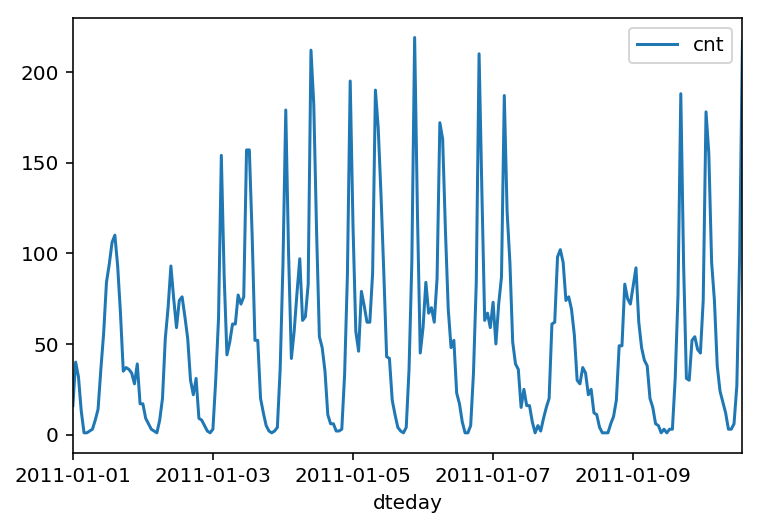

In [2]:
data[:24*10].plot(x='dteday', y='cnt')


In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
datas = data.drop(fields_to_drop, axis=1)
datas.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
print(scaled_features)

{'casual': [35.67621842453536, 49.305030387053186], 'registered': [153.78686920996606, 151.35728591258317], 'cnt': [189.46308763450142, 181.38759909186527], 'temp': [0.4969871684216586, 0.19255612124972407], 'hum': [0.6272288394038822, 0.1929298340629125], 'windspeed': [0.1900976063064631, 0.12234022857279413]}


In [6]:
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [7]:
data=pd.concat([features,targets],axis=1)
data2=data.corr('pearson')


In [8]:
data2
abs(data2.loc['cnt']).sort_values(ascending=False)

cnt           1.000000
registered    0.971892
casual        0.697137
temp          0.404798
atemp         0.400787
                ...   
weekday_6     0.003573
weekday_3     0.003050
weekday_3     0.003050
weekday_2     0.002151
weekday_2     0.002151
Name: cnt, Length: 118, dtype: float64

In [9]:
X=data['registered']
Y=data['cnt']

In [10]:
X = np.array((X - X.min())/(X.max() - X.min()))
Y = np.array((Y - Y.min())/(Y.max() - Y.min()))

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

(array([0.05079007, 0.03950339, 0.0214447 , ..., 0.73250564, 0.51467269,
        0.248307  ]),
 array([0.19074492, 0.61286682, 0.26975169, ..., 0.15801354, 0.4503386 ,
        0.55191874]),
 array([0.04508197, 0.03995902, 0.0204918 , ..., 0.6977459 , 0.48668033,
        0.41086066]),
 array([0.23668033, 0.57991803, 0.26229508, ..., 0.18442623, 0.41905738,
        0.53995902]))

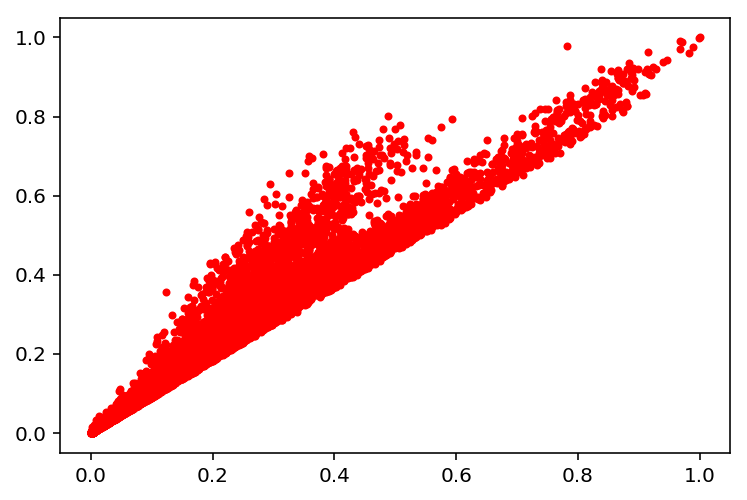

In [12]:
plt.plot(x_train, y_train, 'r.')

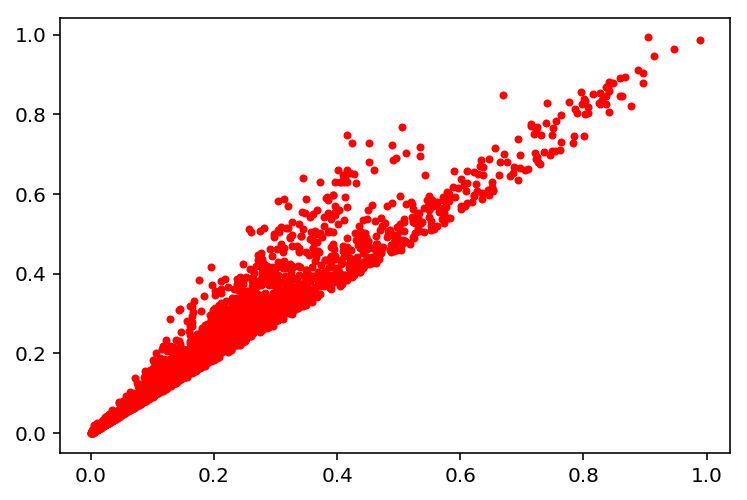

In [13]:
plt.plot(x_test, y_test, 'r.')

In [40]:
def hypothesis(a,b,x):
    return a * x + b

In [41]:
def error(a,b,x,y):
    e = 0
    m = len(y)
    for i in range(m):
        e += np.power((hypothesis(a,b,x[i]) - y[i]), 2)
    
    return (1/(2 * m)) * e

In [42]:
def step_gradient(a,b,x,y,learning_rate):
    grad_a = 0
    grad_b = 0
    m = len(x)
    for i in range(m):
        grad_a += 1/m * (hypothesis(a,b,x[i]) - y[i]) * x[i]
        grad_b += 1/m * (hypothesis(a,b,x[i]) - y[i])
    
    a = a - (grad_a * learning_rate)
    b = b - (grad_b * learning_rate)
    
    return a, b

In [43]:
def descend(initial_a, initial_b, x, y, learning_rate, iterations):
    a = initial_a
    b = initial_b
    for i in range(iterations):
        e = error(a, b, x ,y)
        if i % 1000 == 0:
            print(f"Error: {e}, a: {a}, b: {b}")
        
        a, b = step_gradient(a, b, x, y, learning_rate)

    return a, b

In [44]:
a = 0
b = 1
learning_rate = 0.01
iterations = 10000

final_a, final_b = descend(a, b, x_train, y_train, learning_rate, iterations)

Error: 0.3413983087652513, a: 0, b: 1
Error: 0.012894696331343086, a: 0.15733815629461012, b: 0.17214145390889518
Error: 0.007714702602068989, a: 0.38058772774937333, b: 0.13189970398315207
Error: 0.004784553888344073, a: 0.548498817764903, b: 0.10165184535368524
Error: 0.0031270669385510693, a: 0.6747860975766325, b: 0.07890218845745361
Error: 0.002189482106809908, a: 0.7697677752473125, b: 0.06179198874727371
Error: 0.001659121782210823, a: 0.8412042580552849, b: 0.048923270091079996
Error: 0.0013591147168378426, a: 0.8949322106575487, b: 0.039244603409373253
Error: 0.00118941077199292, a: 0.9353414354312659, b: 0.03196520044484463
Error: 0.0010934149364944092, a: 0.9657335380096167, b: 0.026490302996403512


In [45]:
print(error(a,b,x_train,y_train))
print(error(final_a, final_b, x_train, y_train))
print(error(final_a, final_b, x_test, y_test))

0.3413983087652513
0.0010391133087893217
0.0010349230980504958


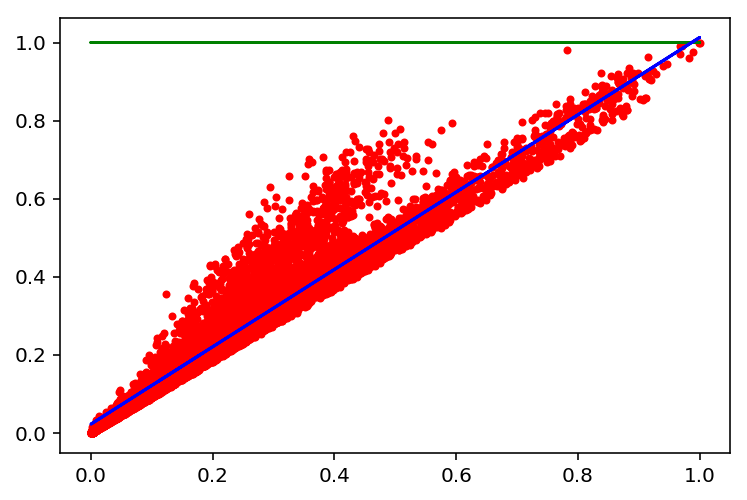

In [22]:
plt.plot(x_train, y_train, 'r.', x_train, hypothesis(a, b, x_train), 'g', x_train, hypothesis(final_a, final_b, x_train), 'b', )

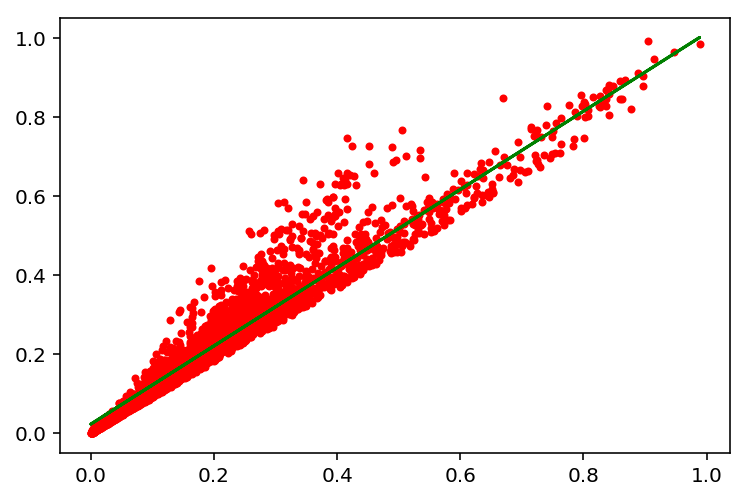

In [23]:
plt.plot(x_test, y_test, 'r.', x_test, hypothesis(final_a, final_b, x_test), 'g')

In [46]:
print(str((1-error(final_a,  final_b, x_test, y_test))*100) + " %")

99.89650769019495 %
